In [1]:
import pickle
import re
import numpy as np
import sys
import os
from glob import glob
import torch
import torch_geometric
import random
import yaml
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import remove_isolated_nodes
from torch import nn
from torch_geometric.nn import GCN2Conv
from torch_geometric.nn import SAGPooling
from torch_geometric.nn import MLP
from torch_geometric.nn import AttentiveFP
from torch_geometric.nn.aggr import AttentionalAggregation
from copy import deepcopy 
from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch.nn import TripletMarginLoss
import importlib.util
from torch_geometric.nn import radius_graph
import itertools
from sklearn.metrics import roc_auc_score
import numpy as np



import torch
import torch.nn.functional as F



In [20]:
root_path     = '/xdisk/twheeler/jgaiser/deepvs3/deepvs/'
params_path   = root_path + 'params.yaml'
config_path   = root_path + 'config.yaml'
function_path = root_path + 'code/utils/data_processing_utils.py'

def load_class_from_file(file_path):
    class_name = file_path.split("/")[-1].split(".")[0]
    spec = importlib.util.spec_from_file_location(class_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return getattr(module, class_name)


def load_function_from_file(file_path):
    function_name = file_path.split("/")[-1].split(".")[0]
    spec = importlib.util.spec_from_file_location(
        os.path.basename(file_path), file_path
    )
    module = importlib.util.module_from_spec(spec)
    sys.modules[spec.name] = module
    spec.loader.exec_module(module)
    return getattr(module, function_name) 


with open(params_path, "r") as param_file:
    params = yaml.safe_load(param_file)
    
with open(config_path, "r") as config_file:
    config = yaml.safe_load(config_file)

mol_graph_ft = params['data_dir'] + config['mol_graph_file_template'] 
poxel_graph_ft = params['data_dir'] + config['vox_embed_graph_file_template']

In [3]:
poxel_data = []
pdb_ids = []
mol_data = {}

for g_file in glob(poxel_graph_ft.replace('%s', '*')):
    g = pickle.load(open(g_file, 'rb'))
    pdb_ids.append(g.pdb_id) 
    poxel_data.append(g)

In [4]:
for g_file in glob(mol_graph_ft.replace('%s', '*')):
    pdb_id = g_file.split('/')[-1].split('_')[0]
    g = pickle.load(open(g_file, 'rb'))
    g.pdb_id = pdb_id
    mol_data[pdb_id] = g

In [5]:
pdbbind_dict = {}
candidate_proteins = []
validation_ids = []

with open('/xdisk/twheeler/jgaiser/data/pdbbind/index_readme/general/index/INDEX_general_PL_name.2020', 'r') as index_in:
    for line_i, line in enumerate(index_in):
        if line[0] == '#':
            continue
        
        line_arr = line.rstrip().split('  ')
         
        if len(line_arr) != 4:
             continue
                
        protein_name = line_arr[-1]
        
        if protein_name not in pdbbind_dict:
            pdbbind_dict[protein_name] = [line_arr[0]]
        else:
            pdbbind_dict[protein_name].append(line_arr[0])
            
for k,v in pdbbind_dict.items():
    if len(v) >= 10 and len(v) <= 15:
        candidate_proteins.append(k)
    
random.shuffle(candidate_proteins)

for k in candidate_proteins:
    if sum([len(x) for x in validation_ids]) > 300:
        break
    
    validation_ids.append(pdbbind_dict[k])

print(len(validation_ids))

25


In [6]:
pox_train_set = []
pox_val_set = []

mol_train_set = []
mol_val_set = []

for pox_sample in poxel_data:
    sample_id = pox_sample.pdb_id
    
    if True in [sample_id in x for x in validation_ids]:
        pox_val_set.append(pox_sample)
        mol_val_set.append(mol_data[pox_sample.pdb_id])
        continue
    
    pox_train_set.append(pox_sample)
    mol_train_set.append(mol_data[pox_sample.pdb_id])
    
def get_random_batch_pair(set_a, set_b, device='cpu', batch_size=32, min_prob=0.1):
    batch_indices = torch.randperm(len(set_a))

    poxel_graph_list = []
    
    for i in batch_indices[:batch_size]:
        g = deepcopy(set_a[i])
#         poxel_graph_list.append(g)
        random_prob = random.randrange(int(min_prob*10), 11) / 10
        random_node_indices = torch.randperm(len(g.x))[:int(len(g.x)*random_prob)]
        g.x = g.x[random_node_indices]
        g.pos = g.pos[random_node_indices]
        poxel_graph_list.append(g)
        
    
    batch_a = Batch.from_data_list(poxel_graph_list)
    batch_b = Batch.from_data_list([set_b[x] for x in batch_indices[:batch_size]])
    return batch_a.to(device), batch_b.to(device)

In [7]:
pox_val_data = []
mol_val_data = []

for target in validation_ids:
    target_poxels = []
    target_mols = []
    
    for pdb_id in target:
        for poxel_graph in pox_val_set:
            if poxel_graph.pdb_id == pdb_id:
                g = deepcopy(poxel_graph)
        #         poxel_graph_list.append(g)
#                 random_prob = random.randrange(int(min_prob*10), 11) / 10
#                 random_prob = 0.4
#                 random_node_indices = torch.randperm(len(g.x))[:int(len(g.x)*random_prob)]
#                 g.x = g.x[random_node_indices]
#                 g.pos = g.pos[random_node_indices]
                target_poxels.append(g)
                
        for mol_graph in mol_val_set:
            if mol_graph.pdb_id == pdb_id:
                target_mols.append(mol_graph)
                
    pox_val_batch = Batch.from_data_list(target_poxels)
    pox_val_data.append(Batch.from_data_list(target_poxels))
    mol_val_data.append(Batch.from_data_list(target_mols))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i in range(len(pox_val_data)):
    pox_val_data[i] = pox_val_data[i].to(device)
    mol_val_data[i] = mol_val_data[i].to(device)

In [8]:
# def spatial_pooling(pos, ptr, res):
#     device = pos.device
#     graph_sizes = ptr[1:]-ptr[:-1]
#     updated_pos = None
#     k_index = torch.tensor([]).long().to(device)
#     updated_ptr = torch.tensor([0]).int().to(device) 
    
#     for ptr_i in range(len(ptr)-1):
#         g_start = ptr[ptr_i]
#         g_stop = ptr[ptr_i+1]
        
#         og_res = torch.diff(torch.unique(pos[g_start:g_stop, 0]))[0].item()
        
#         min_x = torch.min(pos[g_start:g_stop, 0])   
#         min_y = torch.min(pos[g_start:g_stop, 1])   
#         min_z = torch.min(pos[g_start:g_stop, 2])   
        
#         max_x = torch.max(pos[g_start:g_stop, 0])   
#         max_y = torch.max(pos[g_start:g_stop, 1])   
#         max_z = torch.max(pos[g_start:g_stop, 2])   
        
#         x_coords = torch.arange(min_x, max_x+og_res, res)
#         y_coords = torch.arange(min_y, max_y+og_res, res)
#         z_coords = torch.arange(min_z, max_z+og_res, res)
        
#         new_pos = torch.cartesian_prod(x_coords, y_coords, z_coords).to(device)
#         new_indices = torch.argmin(
#                         torch.cdist(new_pos.to(device), 
#                                     pos[g_start:g_stop]), dim=1) + g_start
    
#         if updated_pos == None:
#             updated_pos = new_pos
#         else: 
#             updated_pos = torch.vstack((updated_pos, new_pos))
            
#         updated_ptr = torch.hstack((updated_ptr, updated_ptr[-1]+len(new_indices)))
#         updated_batch = torch.arange(0,len(nptr)-1).to(device).repeat_interleave(graph_sizes)
#         k_index = torch.hstack((k_index, new_indices))
    
        
#     return updated_pos, updated_ptr, k_index 

# pox_batch, mol_batch = get_random_batch_pair(pox_train_set, mol_train_set, device, batch_size=8, min_prob=1)

# pos, nptr, ki=spatial_pooling(pox_batch.pos, pox_batch.ptr, 2)

In [34]:
ac_old_weights = '/xdisk/twheeler/jgaiser/deepvs3/deepvs//models/weights/ac_classifier_7-12.m'
ac_weights = config['active_classifier_weights'] % root_path
pox_agg_weights = config['poxel_aggregator_weights'] % root_path

ac_weights
# if validation_accuracy > prev_validation_accuracy_history:
#     torch.save(ac_model.state_dict(), ac_weights)
#     print('WEIGHTS UPDATED')

'/xdisk/twheeler/jgaiser/deepvs3/deepvs//models/weights/ac_classifier_7-14.m'

In [25]:
PoxelAggregator = load_class_from_file(config['poxel_aggregator_model'] % root_path)
MolEmbedder = load_class_from_file(config['mol_embedder_model'] % root_path)
MolAggregator = load_class_from_file(config['mol_aggregator_model'] % root_path)

config['active_classifier_hyperparams']['in_dim'] = config['mol_aggregator_hyperparams']['out_dim'] + config['poxel_aggregator_hyperparams']['out_dim'] 
    
ActiveClassifier = load_class_from_file(config['active_classifier_model'] % root_path)

ac_model = ActiveClassifier(
    poxel_model=(PoxelAggregator, config['poxel_aggregator_hyperparams']),
    mol_embed_model=(MolEmbedder, config['mol_embedder_hyperparams']),  
    mol_agg_model = (MolAggregator, config['mol_aggregator_hyperparams']),
    **config['active_classifier_hyperparams']).to(device)

ac_model.load_state_dict(torch.load(ac_old_weights))

<All keys matched successfully>

In [32]:
sigmoid = nn.Sigmoid()

def validate(model, pox_val_data, mol_val_data):
    model.eval()
    
    total_auc_scores = []
    total_pos_scores = []
    total_neg_scores = []
    total_mean_scores = []
    all_scores = []
    
    for i in range(len(pox_val_data)):
        print('Evaluating validation target %s' % i)
        val_target_batch = pox_val_data[i]
        val_pos_batch = mol_val_data[i]
        
        target_neg_scores = np.array([])

        for j in range(len(mol_val_data)):
            out, y = model(val_target_batch, 
                           val_pos_batch, 
                           decoy_batch=mol_val_data[j])

            out = sigmoid(out)

            if i == j:
                target_pos_scores = out[torch.where(y==1)[0]].detach().cpu().numpy()
            else:
                negative_scores = out[torch.where(y==0)[0]].detach().cpu().numpy()
                
                if len(target_neg_scores) == 0:
                    target_neg_scores = negative_scores
                    
                target_neg_scores = np.concatenate((target_neg_scores, 
                                                    negative_scores))
                
        # Combine the scores
        scores = np.concatenate([target_pos_scores, target_neg_scores])
        all_scores.append(scores)
        total_mean_scores.append(np.mean(scores))

        # Create labels: 1 for positive class, 0 for negative class
        labels = np.concatenate([np.ones_like(target_pos_scores), 
                                 np.zeros_like(target_neg_scores)])

        # Compute AUC
        auc = roc_auc_score(labels, scores)
        pos_mean = np.mean(target_pos_scores)
        neg_mean = np.mean(target_neg_scores)
        
        total_auc_scores.append(auc)
        total_pos_scores.append(pos_mean)
        total_neg_scores.append(neg_mean)
        
        print(pos_mean, '--', neg_mean)
        print(auc)
        print('----------------------------------')
    
    return np.array(total_auc_scores), np.array(total_pos_scores), np.array(total_neg_scores), np.array(total_mean_scores), all_scores

# a,p,n,m,s = validate(ac_model, pox_val_data, mol_val_data)
# mean_a = np.mean(a)       

# print(np.mean(a))
# print(np.mean(p))
# print(np.mean(n))

Evaluating validation target 0
0.91831946 -- 0.47950795
0.8386066763425254
----------------------------------
Evaluating validation target 1



KeyboardInterrupt



/tmp/ipykernel_17169/1284280601.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(idx)


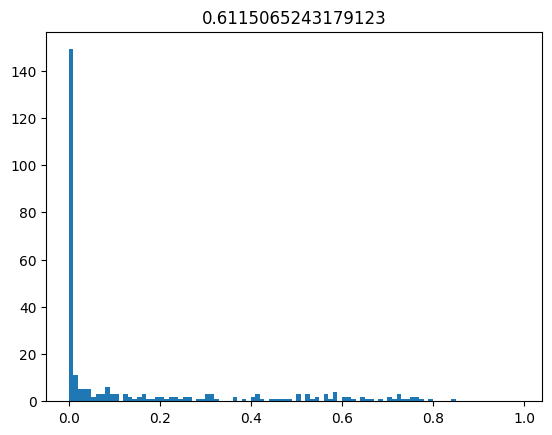

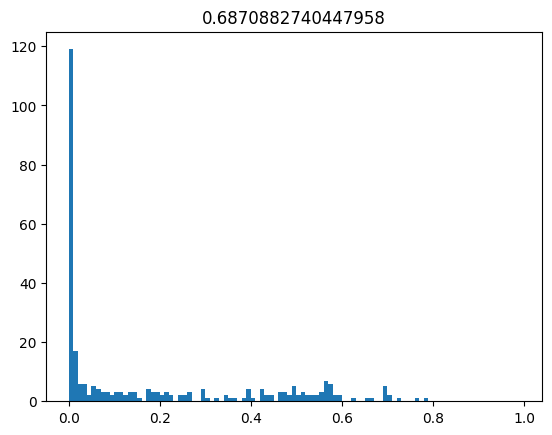

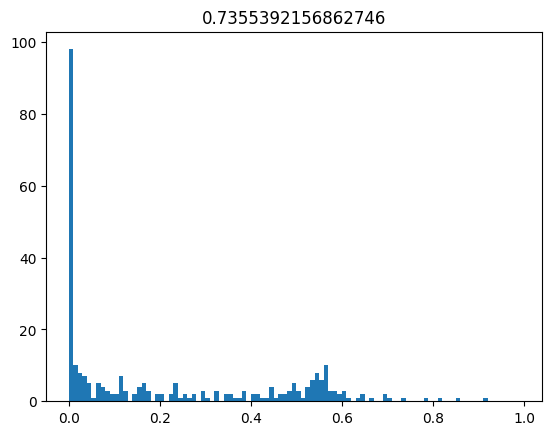

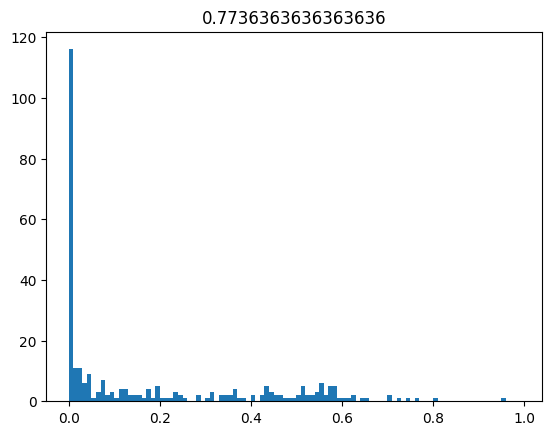

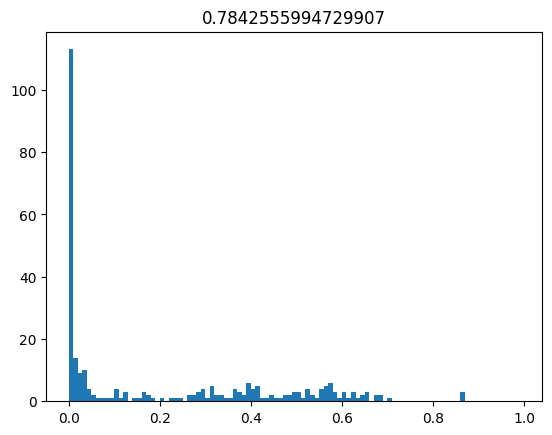

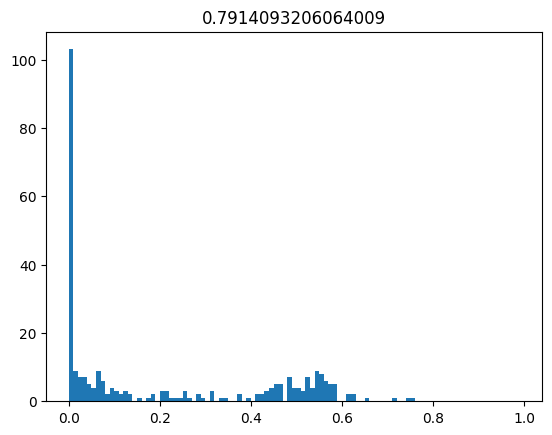

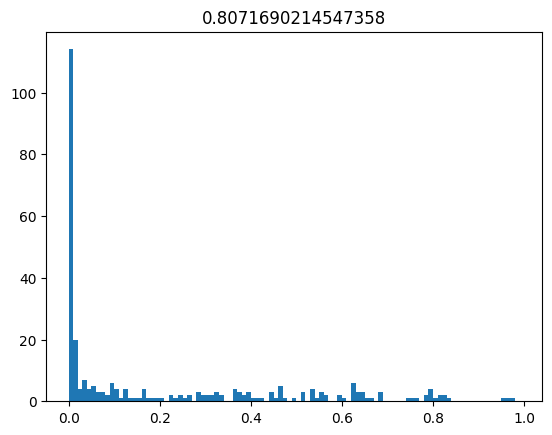

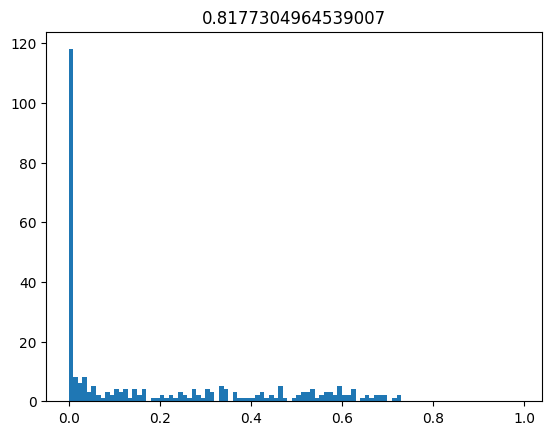

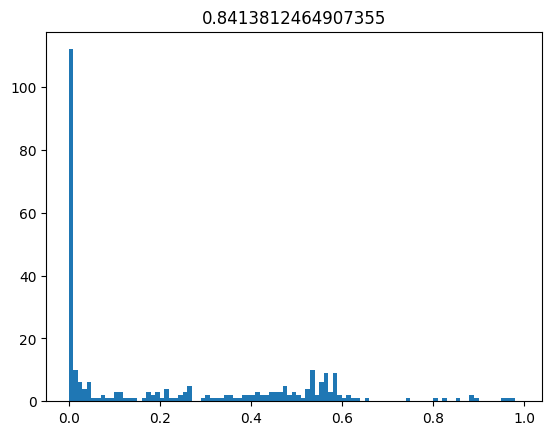

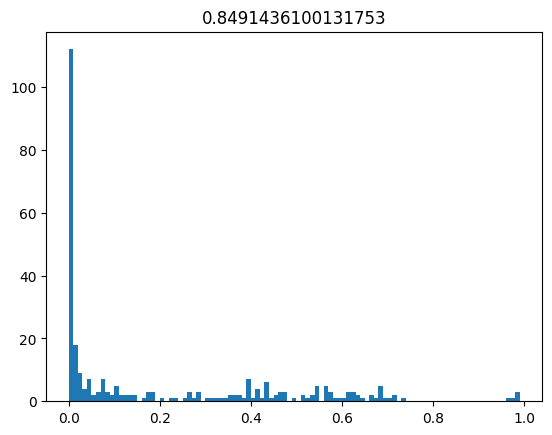

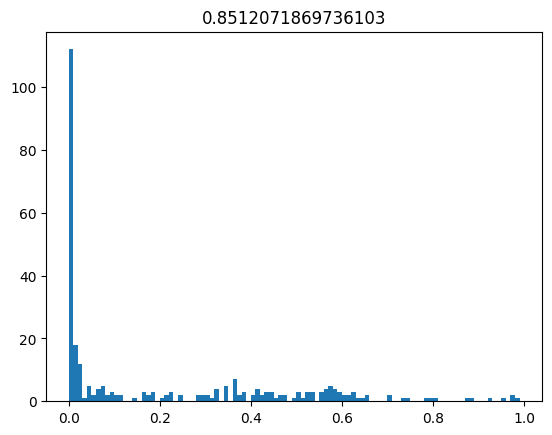

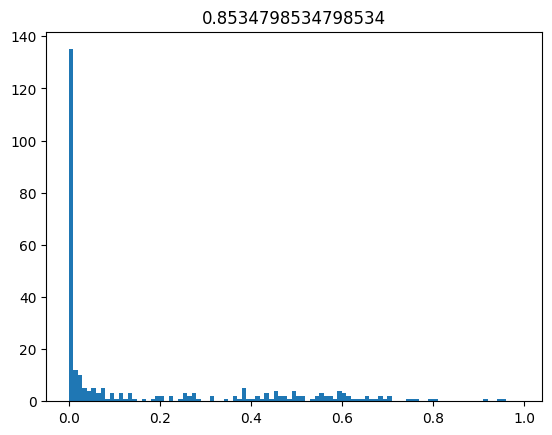

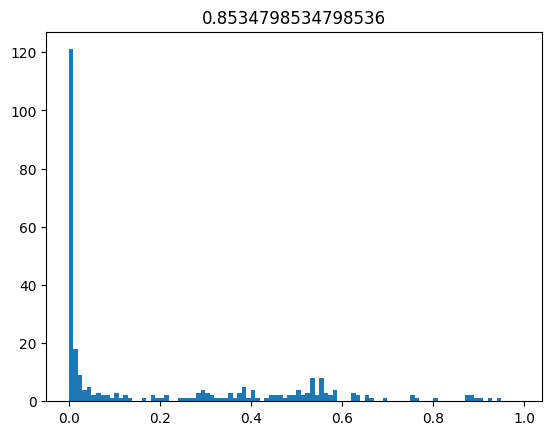

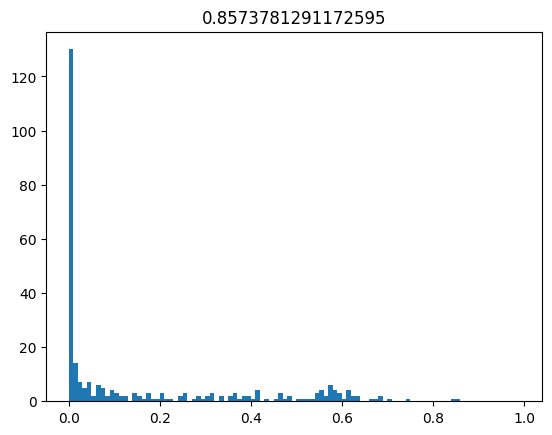

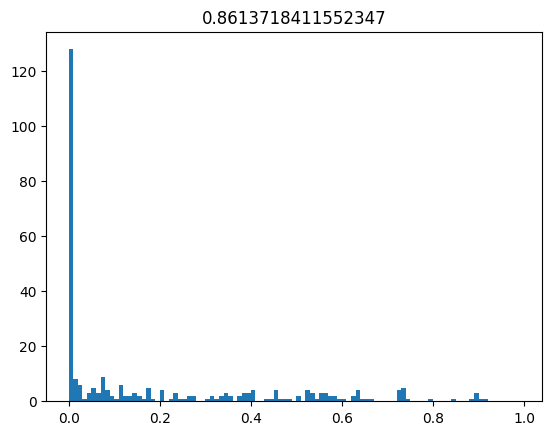

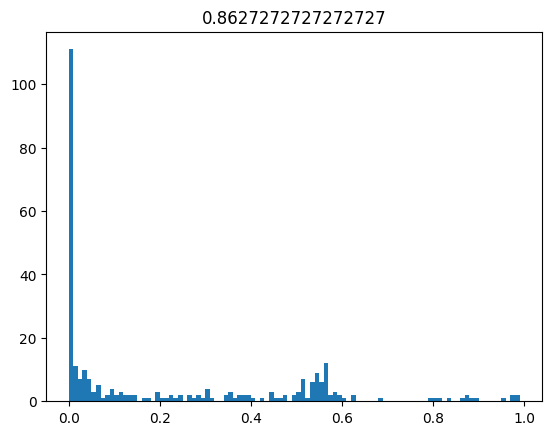

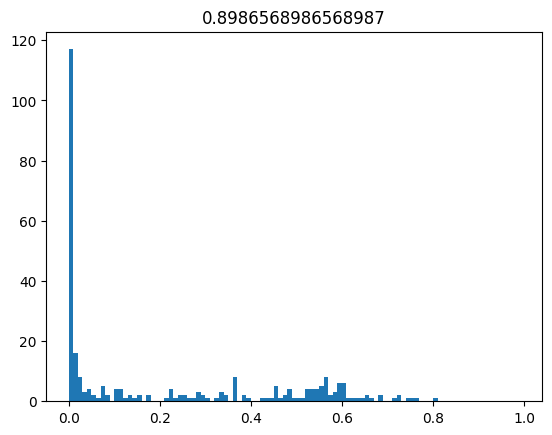

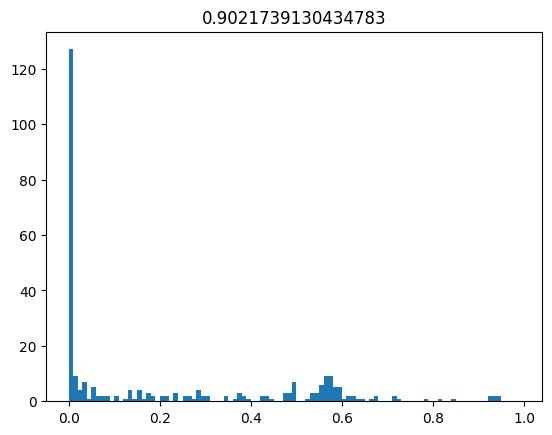

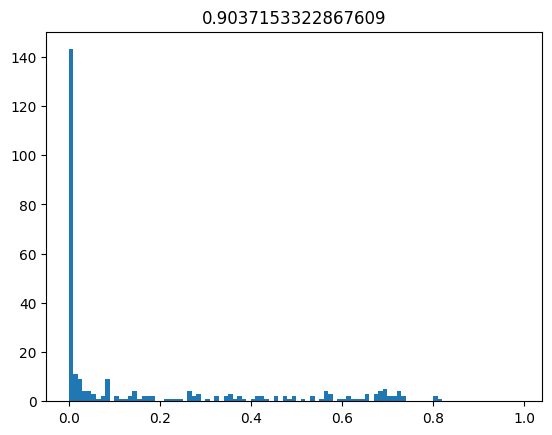

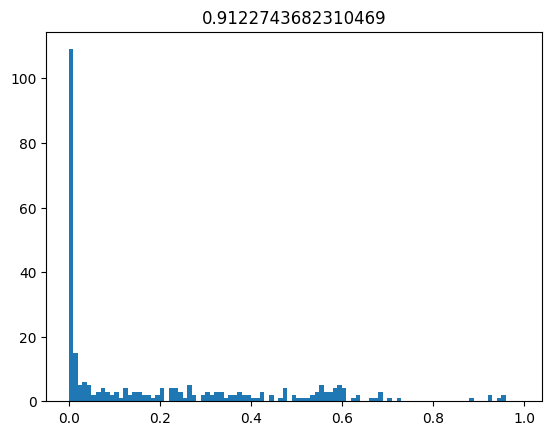

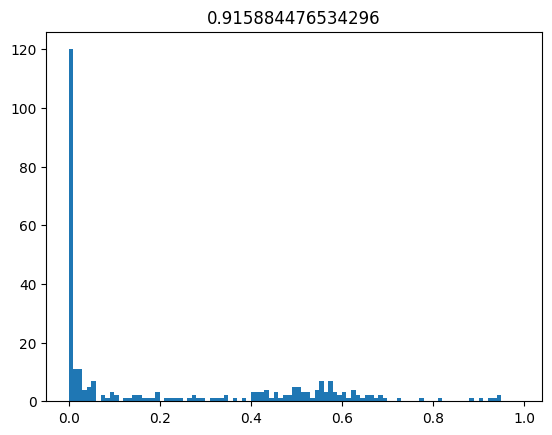

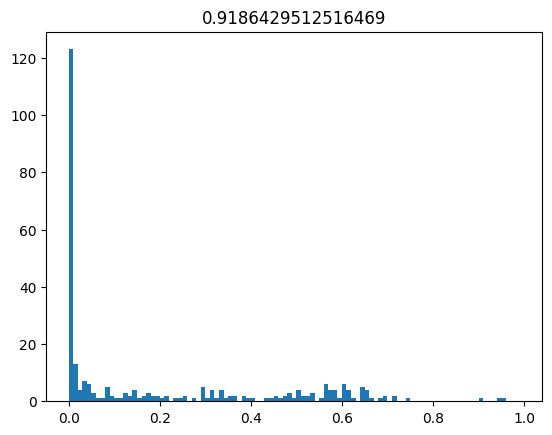

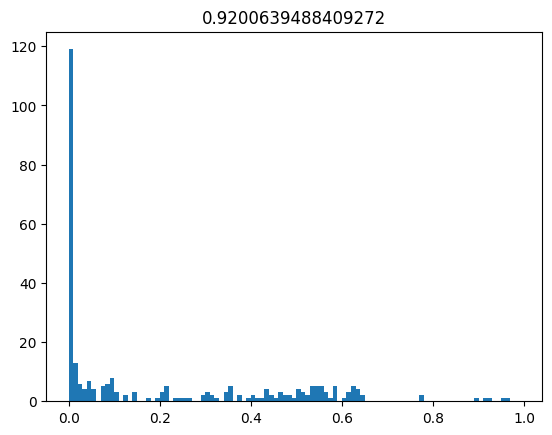

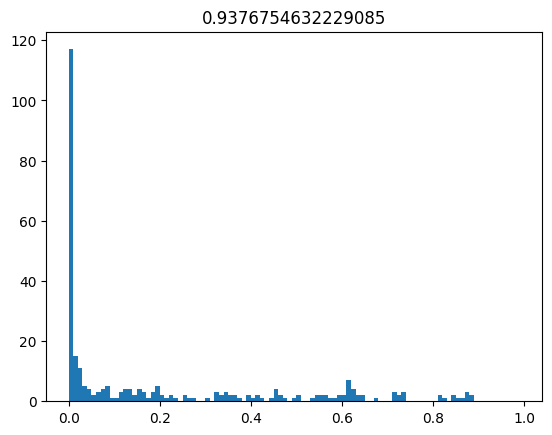

In [59]:
# plt.scatter(p-n, a)
# plt.scatter(m,a)

for i,idx in enumerate(np.argsort(a)):
    plt.figure(idx)
    plt.title(a[idx])
    counts, bins = np.histogram(s[idx], np.arange(100)*0.01)
    plt.stairs(counts,bins, fill=True)

In [ ]:
# torch.manual_seed(1234)
with open(config_path, "r") as config_file:
    config = yaml.safe_load(config_file)
    
PoxelAggregator = load_class_from_file(config['poxel_aggregator_model'] % root_path)

MolEmbedder = load_class_from_file(config['mol_embedder_model'] % root_path)
config['mol_embedder_hyperparams']['weights'] = config['mol_embedder_weights']

MolAggregator = load_class_from_file(config['mol_aggregator_model'] % root_path)

config['active_classifier_hyperparams']['in_dim'] = config['mol_aggregator_hyperparams']['out_dim'] + config['poxel_aggregator_hyperparams']['out_dim'] 
    
ActiveClassifier = load_class_from_file(config['active_classifier_model'] % root_path)

ac_model = ActiveClassifier(
    poxel_model=(PoxelAggregator, config['poxel_aggregator_hyperparams']),
    mol_embed_model=(MolEmbedder, config['mol_embedder_hyperparams']),  
    mol_agg_model = (MolAggregator, config['mol_aggregator_hyperparams']),
    **config['active_classifier_hyperparams']).to(device)

BATCH_SIZE = 16  
NEG_BATCH_SIZE = 16
# optimizer = torch.optim.AdamW(ac_model.parameters(), lr=1e-5)
optimizer = torch.optim.Adam(ac_model.parameters(), lr=1e-5)
# decoy_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([32])).to(device) 
decoy_loss = nn.BCEWithLogitsLoss().to(device) 
    
ac_model.train()
# ac_model.eval()
best_a = 0.8

for epoch in range(1, 100):
    for batch_index in range(int(len(pox_train_set) / BATCH_SIZE)):  
        pox_batch, mol_batch = get_random_batch_pair(pox_train_set, mol_train_set, device, batch_size=BATCH_SIZE, min_prob=0.1)
        decoy_pocket_batch, _ = get_random_batch_pair(pox_train_set, mol_train_set, device, batch_size=NEG_BATCH_SIZE, min_prob=0.1)
        _, decoy_mol_batch = get_random_batch_pair(pox_train_set, mol_train_set, device, batch_size=NEG_BATCH_SIZE, min_prob=0.1)
        
        out, y = ac_model(pox_batch, mol_batch, decoy_pocket_batch, decoy_mol_batch)
        
        pos_indices = torch.where(y==1)[0]
        neg_indices = torch.where(y==0)[0]
            
        l1 = decoy_loss(out, y.unsqueeze(1).to(device))
        l1.backward()
        optimizer.step()
        
        if batch_index % 100 == 0:
            print('--------------------------------------------')
            print(l1.item())
            print('----')
            print(" ".join(["%.3f" % x for x in sigmoid(out[pos_indices].flatten())]))
            print(torch.mean(sigmoid(out[pos_indices].flatten())))
            print('----')
            print(" ".join(["%.3f" % x for x in sigmoid(out[neg_indices].flatten())]))
            print(torch.mean(sigmoid(out[neg_indices].flatten())))
            
    print("EPOCH %s COMPLETE" % (epoch))
    
#     if (epoch+1) % 5 == 0:
#         ac_model.eval()
        
    if epoch % 3 == 0:
        a,p,n,_,_ = validate(ac_model, pox_val_data, mol_val_data)
        mean_a = np.mean(a)       
        
        print(np.mean(a))
        print(np.mean(p))
        print(np.mean(n))
        
        if mean_a > best_a:
            torch.save(ac_model.state_dict(), ac_weights)
            print('WEIGHTS UPDATED')
            best_a = mean_a
            
        ac_model.train()
             
        


--------------------------------------------
0.6806640028953552
----
0.761 0.702 0.410 0.459 0.567 0.602 0.442 0.694 0.454 0.592 0.459 0.562 0.435 0.522 0.312 0.358
tensor(0.5207, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.274 0.573 0.209 0.742 0.436 0.661 0.514 0.619 0.281 0.300 0.573 0.420 0.513 0.540 0.509 0.390
tensor(0.4721, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.7780070900917053
----
0.528 0.508 0.434 0.596 0.488 0.594 0.121 0.610 0.346 0.598 0.813 0.411 0.598 0.387 0.220 0.654
tensor(0.4942, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.451 0.389 0.546 0.405 0.558 0.540 0.294 0.713 0.593 0.297 0.812 0.488 0.460 0.515 0.558 0.624
tensor(0.5151, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.961225688457489
----
0.544 0.715 0.620 0.548 0.555 0.822 0.834 0.429 0.401 0.777 0.434 0.049 0.612 0.069 0.188 0.664
tensor(0.5163, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.619 0.704 0.

EPOCH 2 COMPLETE
--------------------------------------------
0.5707347393035889
----
0.520 0.463 0.367 0.451 0.916 0.344 0.570 0.790 0.783 0.920 0.418 0.802 0.706 0.616 0.601 0.655
tensor(0.6201, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.014 0.544 0.157 0.574 0.108 0.649 0.214 0.526 0.496 0.684 0.517 0.016 0.453 0.551 0.662 0.577
tensor(0.4213, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.7257915735244751
----
0.713 0.401 0.865 0.751 0.622 0.468 0.658 0.574 0.017 0.560 0.709 0.710 0.653 0.787 0.670 0.607
tensor(0.6102, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.427 0.811 0.622 0.771 0.547 0.644 0.327 0.180 0.042 0.670 0.001 0.421 0.821 0.407 0.538 0.461
tensor(0.4807, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.6319893002510071
----
0.451 0.475 0.358 0.462 0.615 0.493 0.670 0.834 0.673 0.655 0.353 0.495 0.758 0.908 0.580 0.495
tensor(0.5797, device='cuda:0', grad_fn=<MeanBackward0>)
-

--------------------------------------------
0.7404364943504333
----
0.346 0.859 0.348 0.829 0.201 0.350 0.170 0.823 0.865 0.158 0.246 0.510 0.539 0.251 0.947 0.818
tensor(0.5162, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.860 0.282 0.310 0.920 0.090 0.337 0.244 0.369 0.396 0.518 0.149 0.427 0.394 0.205 0.579 0.265
tensor(0.3965, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.6179096102714539
----
0.464 0.941 0.327 0.672 0.504 0.482 0.783 0.703 0.891 0.305 0.240 0.301 0.495 0.910 0.410 0.877
tensor(0.5815, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.470 0.596 0.011 0.290 0.945 0.321 0.413 0.576 0.273 0.244 0.036 0.335 0.407 0.363 0.291 0.519
tensor(0.3806, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.7656611204147339
----
0.284 0.448 0.065 0.378 0.904 0.686 0.886 0.679 0.471 0.604 0.678 0.559 0.787 0.722 0.507 0.322
tensor(0.5613, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.115 0.435 0

--------------------------------------------
0.6635448932647705
----
0.090 0.569 0.629 0.524 0.655 0.672 0.781 0.892 0.607 0.581 0.295 0.485 0.322 0.821 0.713 0.481
tensor(0.5697, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.008 0.674 0.404 0.721 0.535 0.765 0.649 0.017 0.445 0.016 0.529 0.166 0.670 0.367 0.716 0.008
tensor(0.4181, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.7152705788612366
----
0.373 0.815 0.324 0.182 0.650 0.274 0.527 0.842 0.798 0.821 0.777 0.665 0.700 0.753 0.574 0.286
tensor(0.5851, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.859 0.787 0.524 0.556 0.051 0.845 0.478 0.001 0.559 0.336 0.819 0.096 0.000 0.131 0.671 0.585
tensor(0.4561, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.7406843900680542
----
0.716 0.396 0.763 0.240 0.764 0.781 0.345 0.588 0.772 0.080 0.861 0.425 0.888 0.727 0.338 0.348
tensor(0.5645, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.009 0.174 0

EPOCH 7 COMPLETE
--------------------------------------------
0.5496068596839905
----
0.577 0.964 0.636 0.558 0.751 0.586 0.523 0.899 0.690 0.651 0.706 0.534 0.265 0.555 0.205 0.689
tensor(0.6119, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.000 0.051 0.402 0.376 0.480 0.116 0.207 0.510 0.650 0.155 0.561 0.393 0.627 0.698 0.647 0.193
tensor(0.3791, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
1.1204273700714111
----
0.423 0.520 0.586 0.389 0.164 0.495 0.391 0.391 0.557 0.540 0.252 0.473 0.489 0.004 0.506 0.611
tensor(0.4244, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.531 0.600 0.280 0.324 0.269 1.000 0.784 0.169 0.550 0.101 0.564 0.383 0.431 0.470 0.447 0.046
tensor(0.4342, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.6108789443969727
----
0.505 0.591 1.000 0.686 0.564 0.584 0.113 0.724 0.314 0.761 0.140 0.886 0.205 0.623 0.758 0.483
tensor(0.5585, device='cuda:0', grad_fn=<MeanBackward0>)
-

EPOCH 9 COMPLETE
Evaluating validation target 0
0.73003346 -- 0.5394264
0.7480406386066764
----------------------------------
Evaluating validation target 1
0.7495791 -- 0.52613485
0.7411287597161204
----------------------------------
Evaluating validation target 2
0.7042221 -- 0.53761595
0.7338181818181818
----------------------------------
Evaluating validation target 3
0.73860925 -- 0.51764596
0.7263681592039801
----------------------------------
Evaluating validation target 4
0.7052004 -- 0.4876371
0.727037037037037
----------------------------------
Evaluating validation target 5
0.66782105 -- 0.53037375
0.6116931395741804
----------------------------------
Evaluating validation target 6
0.69080234 -- 0.51579547
0.6800373134328359
----------------------------------
Evaluating validation target 7
0.6677694 -- 0.5585787
0.6407407407407407
----------------------------------
Evaluating validation target 8
0.7384393 -- 0.4407755
0.7741284932296169
----------------------------------
Eva

--------------------------------------------
0.5348942279815674
----
0.990 0.500 0.547 0.936 0.557 0.533 0.574 0.790 0.557 0.611 0.847 0.523 0.459 0.667 0.680 0.622
tensor(0.6495, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.519 0.000 0.576 0.539 0.528 0.541 0.298 0.007 0.497 0.656 0.779 0.060 0.627 0.315 0.575 0.000
tensor(0.4073, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.6917288899421692
----
0.903 0.405 0.699 0.526 0.351 0.384 0.881 0.688 0.996 0.651 0.498 0.488 0.375 0.483 0.521 0.369
tensor(0.5762, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.508 0.440 0.711 0.979 0.627 0.409 0.569 0.112 0.000 0.183 0.003 0.622 0.473 0.083 0.328 0.708
tensor(0.4223, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.8135170936584473
----
0.662 0.346 0.005 0.631 0.458 0.915 0.646 0.667 0.996 0.319 0.746 0.329 0.363 0.471 0.292 0.675
tensor(0.5325, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.556 0.595 0

0.47104678 -- 0.35368228
0.6372180451127819
----------------------------------
Evaluating validation target 13
0.56391865 -- 0.40256104
0.708955223880597
----------------------------------
Evaluating validation target 14
0.5491316 -- 0.4072289
0.6822222222222222
----------------------------------
Evaluating validation target 15
0.7212251 -- 0.4718302
0.7382246376811594
----------------------------------
Evaluating validation target 16
0.5029797 -- 0.45657846
0.5491212906943245
----------------------------------
Evaluating validation target 17
0.5764869 -- 0.47027436
0.6370395403852652
----------------------------------
Evaluating validation target 18
0.6519253 -- 0.43633026
0.7434944237918215
----------------------------------
Evaluating validation target 19
0.58008915 -- 0.38358554
0.7433333333333333
----------------------------------
Evaluating validation target 20
0.49455813 -- 0.4020064
0.6433941997851773
----------------------------------
Evaluating validation target 21
0.55273205

--------------------------------------------
0.7142916917800903
----
0.709 0.121 0.415 0.513 0.205 0.954 0.315 0.699 0.806 0.539 0.759 0.963 0.729 0.251 0.783 0.682
tensor(0.5903, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.055 0.583 0.000 0.249 0.826 0.753 0.801 0.801 0.185 0.621 0.055 0.289 0.002 0.604 0.571 0.727
tensor(0.4452, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.5441229343414307
----
0.699 0.565 0.819 0.804 0.320 0.784 0.807 1.000 0.761 0.802 0.573 0.730 0.649 0.709 0.503 0.433
tensor(0.6849, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.181 0.766 0.001 0.008 0.784 0.245 0.542 0.297 0.298 0.754 0.746 0.802 0.506 0.523 0.001 0.000
tensor(0.4034, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.5444694757461548
----
0.875 0.440 0.786 0.821 0.785 0.735 0.277 0.801 0.763 0.999 0.781 0.316 0.399 0.351 0.767 0.696
tensor(0.6620, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.804 0.207 0

0.51181334 -- 0.34308073
0.679496855345912
----------------------------------
Evaluating validation target 24
0.33630574 -- 0.33821246
0.6209386281588447
----------------------------------
0.656357117149862
0.52571046
0.38379398
--------------------------------------------
0.6280251741409302
----
0.868 0.404 0.999 0.779 0.183 0.798 0.365 1.000 0.173 0.273 0.609 0.447 0.306 0.148 0.440 0.739
tensor(0.5331, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.375 0.483 0.154 0.058 0.421 0.000 0.834 0.367 0.204 0.348 0.349 0.278 0.247 0.317 0.361 0.453
tensor(0.3283, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.5579214692115784
----
0.437 0.475 0.686 0.205 0.416 0.385 0.762 0.394 0.994 1.000 0.656 0.536 0.414 0.580 0.363 0.414
tensor(0.5448, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.198 0.681 0.544 0.020 0.361 0.244 0.292 0.232 0.285 0.407 0.340 0.687 0.367 0.129 0.003 0.310
tensor(0.3188, device='cuda:0', grad_fn=<MeanBackward0>)
-----------

--------------------------------------------
0.7349857091903687
----
0.677 0.761 0.539 0.579 0.988 0.557 0.528 0.321 0.617 0.681 0.370 0.619 0.691 0.034 0.778 0.616
tensor(0.5848, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.000 0.121 0.454 0.508 0.695 0.475 0.698 0.741 0.553 0.691 0.000 0.696 0.596 0.684 0.539 0.486
tensor(0.4962, device='cuda:0', grad_fn=<MeanBackward0>)
EPOCH 17 COMPLETE
--------------------------------------------
0.5643743276596069
----
0.859 0.682 0.724 0.717 0.637 0.164 0.755 0.707 0.606 0.699 0.487 0.721 0.635 0.862 0.587 0.883
tensor(0.6703, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.046 0.415 0.563 0.000 0.858 0.632 0.434 0.701 0.288 0.000 0.827 0.105 0.313 0.675 0.019 0.614
tensor(0.4056, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.8735085725784302
----
0.802 0.700 0.542 0.000 0.814 0.567 0.578 0.668 0.728 0.524 0.448 0.819 0.736 0.592 0.851 0.207
tensor(0.5985, device='cuda:0', grad_fn=<MeanBackward0>)


--------------------------------------------
0.9099820852279663
----
0.932 0.467 0.604 0.350 0.619 0.179 0.531 0.052 0.623 0.772 0.606 0.582 0.350 0.613 0.421 1.000
tensor(0.5438, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.566 0.478 0.001 0.001 1.000 0.534 0.513 0.491 0.317 0.338 0.413 0.550 0.296 0.524 0.870 0.205
tensor(0.4436, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.7492573261260986
----
0.495 0.444 1.000 0.525 0.616 0.542 0.481 0.481 0.314 1.000 0.838 0.139 0.529 0.486 0.552 0.477
tensor(0.5575, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.996 0.000 0.073 0.392 0.199 0.812 0.594 0.499 0.152 0.277 0.672 0.545 0.202 0.001 0.407 0.435
tensor(0.3910, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.5698882937431335
----
0.997 0.467 0.362 0.982 0.991 0.520 0.896 0.743 0.494 0.586 0.654 0.332 0.387 0.530 0.297 0.646
tensor(0.6179, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.513 0.005 0

--------------------------------------------
0.6935268640518188
----
0.978 0.582 0.237 0.430 0.701 0.598 0.295 0.414 0.620 0.375 0.650 0.665 0.065 0.666 0.107 0.999
tensor(0.5239, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.504 0.501 0.584 0.329 0.028 0.096 0.521 0.390 0.448 0.744 0.027 0.334 0.000 0.572 0.672 0.263
tensor(0.3759, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.5525636076927185
----
0.658 0.469 0.371 0.789 0.670 0.989 0.584 0.573 0.613 0.385 0.693 0.998 0.359 0.408 0.637 0.629
tensor(0.6141, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.542 0.360 0.004 0.576 0.227 0.637 0.371 0.583 0.823 0.175 0.072 0.603 0.398 0.382 0.402 0.000
tensor(0.3847, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.7147860527038574
----
0.442 0.514 0.132 0.506 0.611 0.488 0.690 0.328 0.591 0.658 0.635 0.477 0.935 0.214 0.901 0.247
tensor(0.5231, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.505 0.590 0

--------------------------------------------
0.5853521823883057
----
0.606 0.802 0.675 0.452 0.179 0.590 0.868 0.722 0.643 0.581 0.735 0.565 0.543 0.492 0.636 0.565
tensor(0.6035, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.624 0.476 0.000 0.018 0.279 0.588 0.545 0.664 0.680 0.506 0.195 0.005 0.692 0.682 0.510 0.068
tensor(0.4082, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.5349156260490417
----
0.703 0.681 0.500 0.738 0.709 0.680 0.560 0.999 0.389 0.641 0.547 0.652 0.445 0.745 0.458 0.646
tensor(0.6308, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.713 0.546 0.047 0.588 0.569 0.638 0.610 0.000 0.539 0.027 0.468 0.369 0.420 0.669 0.015 0.000
tensor(0.3886, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.514657199382782
----
0.760 0.688 0.567 0.996 0.665 0.599 0.999 0.596 0.891 0.590 0.575 0.545 0.533 0.529 0.633 0.537
tensor(0.6689, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.590 0.754 0.

--------------------------------------------
0.7367956638336182
----
0.602 0.569 0.927 0.643 0.656 0.393 0.610 0.546 0.000 0.703 0.685 0.607 0.709 0.671 0.648 0.789
tensor(0.6100, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.644 0.044 0.264 0.456 0.666 0.503 0.231 0.014 0.683 0.000 0.095 0.002 0.004 0.294 0.002 0.250
tensor(0.2595, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.5915005803108215
----
0.535 0.981 0.500 0.403 0.698 0.521 0.643 0.378 0.069 0.443 0.512 0.389 0.811 0.356 0.483 0.426
tensor(0.5092, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.000 0.511 0.406 0.333 0.670 0.375 0.000 0.405 0.345 0.129 0.467 0.218 0.302 0.476 0.014 0.123
tensor(0.2985, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
1.0926201343536377
----
0.577 0.356 0.566 0.000 0.426 0.071 0.281 0.940 0.991 0.463 0.804 0.652 0.623 0.375 0.526 0.463
tensor(0.5072, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.298 0.184 0

EPOCH 25 COMPLETE
--------------------------------------------
0.8906952142715454
----
0.587 0.576 0.771 0.229 0.526 0.359 0.474 0.547 0.591 0.761 0.000 0.619 0.659 0.621 0.690 0.433
tensor(0.5276, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.005 0.490 0.509 0.070 0.581 0.668 0.531 0.555 0.049 0.002 0.000 0.817 0.525 0.125 0.707 0.024
tensor(0.3536, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.5990840792655945
----
0.811 0.750 0.743 0.167 0.755 0.727 0.655 0.690 0.727 0.673 0.938 0.845 0.721 0.019 0.476 0.626
tensor(0.6451, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.005 0.689 0.670 0.000 0.019 0.000 0.684 0.711 0.732 0.239 0.000 0.091 0.715 0.544 0.154 0.155
tensor(0.3381, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.6920573115348816
----
0.837 0.650 0.388 0.567 0.112 0.610 0.583 0.631 0.368 0.979 0.624 0.139 0.770 0.497 0.388 0.598
tensor(0.5463, device='cuda:0', grad_fn=<MeanBackward0>)


EPOCH 27 COMPLETE
Evaluating validation target 0
0.732659 -- 0.56830746
0.7538461538461538
----------------------------------
Evaluating validation target 1
0.71102554 -- 0.5126505
0.729300439337614
----------------------------------
Evaluating validation target 2
0.69416714 -- 0.52655256
0.8079999999999999
----------------------------------
Evaluating validation target 3
0.701025 -- 0.5084535
0.7120646766169155
----------------------------------
Evaluating validation target 4
0.7335719 -- 0.51553315
0.7333333333333334
----------------------------------
Evaluating validation target 5
0.66327477 -- 0.50414085
0.682663061845218
----------------------------------
Evaluating validation target 6
0.682529 -- 0.5607334
0.7251243781094527
----------------------------------
Evaluating validation target 7
0.6218776 -- 0.5371357
0.7192592592592594
----------------------------------
Evaluating validation target 8
0.74156225 -- 0.4947823
0.8066839527513685
----------------------------------
Evaluat

--------------------------------------------
0.6297063827514648
----
0.700 0.769 0.702 0.638 0.745 0.529 1.000 0.650 0.768 0.653 0.478 0.769 0.790 0.825 0.931 0.785
tensor(0.7332, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.059 0.625 0.791 0.540 0.628 0.244 0.008 0.112 0.990 0.495 0.000 0.700 0.584 0.064 0.761 0.732
tensor(0.4582, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.6241207122802734
----
0.748 0.690 0.736 0.572 0.691 0.369 0.428 0.444 0.723 0.612 0.429 0.669 0.634 1.000 0.740 0.683
tensor(0.6355, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.020 0.689 0.665 0.643 0.731 0.000 0.292 0.000 0.246 0.839 0.700 0.524 0.256 0.718 0.523 0.589
tensor(0.4647, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.44546693563461304
----
0.691 0.731 0.386 0.655 0.896 0.558 0.804 0.678 0.720 0.699 0.999 0.697 0.509 0.732 0.784 0.662
tensor(0.7001, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.694 0.372 

0.5130265 -- 0.41236532
0.6082169709989259
----------------------------------
Evaluating validation target 13
0.64324284 -- 0.39952034
0.8100124378109452
----------------------------------
Evaluating validation target 14
0.51247424 -- 0.45990652
0.5551851851851852
----------------------------------
Evaluating validation target 15
0.63181114 -- 0.40244076
0.7373188405797102
----------------------------------
Evaluating validation target 16
0.5891714 -- 0.43982676
0.6418899452607318
----------------------------------
Evaluating validation target 17
0.5561362 -- 0.4814823
0.5971612031091584
----------------------------------
Evaluating validation target 18
0.6590357 -- 0.4174902
0.8026360256843528
----------------------------------
Evaluating validation target 19
0.66381377 -- 0.4215483
0.7774074074074074
----------------------------------
Evaluating validation target 20
0.5449429 -- 0.40646076
0.676423200859291
----------------------------------
Evaluating validation target 21
0.62421 --

--------------------------------------------
0.5691375732421875
----
0.753 1.000 0.864 0.745 0.575 0.616 0.869 0.788 0.738 0.843 0.757 0.891 0.763 0.785 0.461 0.320
tensor(0.7355, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.001 0.647 0.000 0.223 0.723 0.589 0.113 0.789 0.683 0.757 0.425 0.518 0.769 0.000 0.605 0.753
tensor(0.4746, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.44786983728408813
----
0.772 0.674 0.745 0.888 0.750 0.773 0.781 1.000 0.821 0.764 0.862 0.723 0.750 0.775 0.451 0.728
tensor(0.7660, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.124 0.575 0.844 0.075 0.787 0.258 0.000 0.767 0.258 0.267 0.723 0.165 0.004 0.248 0.722 0.012
tensor(0.3642, device='cuda:0', grad_fn=<MeanBackward0>)
--------------------------------------------
0.4973617494106293
----
0.604 0.604 0.376 0.726 0.863 0.964 0.998 0.446 0.852 0.655 0.939 0.649 0.488 0.682 0.539 0.650
tensor(0.6896, device='cuda:0', grad_fn=<MeanBackward0>)
----
0.614 0.641 

In [13]:
total = 0

for item in pox_val_data:
    total += len(pox_val_data[0].pdb_id)
    
print(total)

288


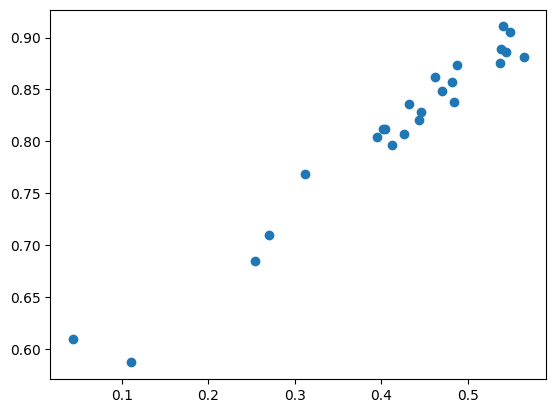

In [4]:
import numpy as np
import matplotlib.pyplot as plt

a_scores = [0.8377659574468085,0.8622931442080377,0.9056338028169014,0.8815559440559441,0.8737244897959184,0.7961267605633803,0.886499402628435,0.7690140845070422,0.7102272727272728,0.8355633802816901,0.684826762246117,0.8119718309859155,0.5869718309859154,0.8073979591836734,0.9106970767748153,0.8891322200930742,0.8571428571428571,0.6093567251461989,0.8485915492957746,0.8283602518477964,0.811734693877551,0.8752551020408164,0.8207885304659498,0.8043687761002248]
d_vals = [abs(0.84219074 - 0.35872927),abs(0.78048396 - 0.31875956),abs(0.8853347 - 0.33667675),abs(0.8541175 - 0.2895893),abs(0.78446245 - 0.2968841),abs(0.7723557 - 0.3606827),abs(0.8516069 - 0.30817115),abs(0.62065554 - 0.30877745),abs(0.66286755 - 0.39227843),abs(0.782352 - 0.3509571),abs(0.62689215 - 0.3728994),abs(0.71885324 - 0.31436893),abs(0.46247095 - 0.35130188),abs(0.7682741 - 0.3426099),abs(0.88207245 - 0.34160677),abs(0.8822334 - 0.34361222),abs(0.8085766 - 0.3275813),abs(0.3846034 - 0.34089655),abs(0.75409204 - 0.28373504),abs(0.79034483 - 0.3445796),abs(0.7627498 - 0.36125392),abs(0.8337536 - 0.29673812),abs(0.76386416 - 0.32023007),abs(0.72667223 - 0.3316181)]
m_vals = [abs(0.84219074 - 0.35872927),abs(0.78048396 - 0.31875956),abs(0.8853347 - 0.33667675),abs(0.8541175 - 0.2895893),abs(0.78446245 - 0.2968841),abs(0.7723557 - 0.3606827),abs(0.8516069 - 0.30817115),abs(0.62065554 - 0.30877745),abs(0.66286755 - 0.39227843),abs(0.782352 - 0.3509571),abs(0.62689215 - 0.3728994),abs(0.71885324 - 0.31436893),abs(0.46247095 - 0.35130188),abs(0.7682741 - 0.3426099),abs(0.88207245 - 0.34160677),abs(0.8822334 - 0.34361222),abs(0.8085766 - 0.3275813),abs(0.3846034 - 0.34089655),abs(0.75409204 - 0.28373504),abs(0.79034483 - 0.3445796),abs(0.7627498 - 0.36125392),abs(0.8337536 - 0.29673812),abs(0.76386416 - 0.32023007),abs(0.72667223 - 0.3316181)]

average_auc = 0.8127083502174214
mean_active = 0.7500784
mean_decoy = 0.3331057

plt.scatter(d_vals, a_scores)
plt.show()

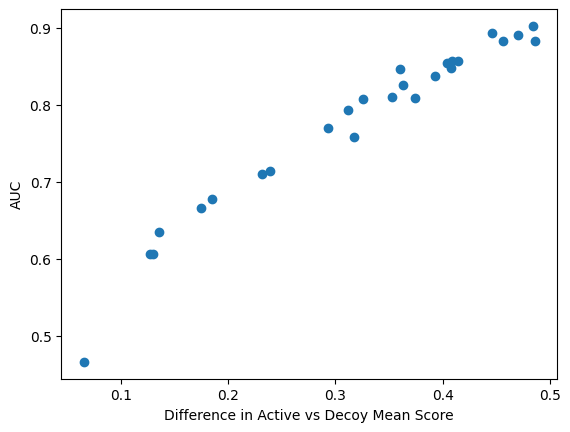

In [41]:
import numpy as np
import matplotlib.pyplot as plt

a = [0.7927318295739348, 0.8538062283737023, 0.8374570446735394, 0.9025106837606838, 0.8255478662053056, 0.6062639821029083, 0.8563573883161513, 0.7695945945945946, 0.8835051546391753, 0.4659863945578231, 0.8081134892981583, 0.7103092783505155, 0.8938356164383562, 0.8830721003134797, 0.6777003484320557, 0.6060228969636635, 0.7580756013745705, 0.8092948717948718, 0.8103448275862069, 0.7140368342458935, 0.8461538461538461, 0.8480392156862745, 0.6350515463917525, 0.8567398119122257, 0.890282131661442, 0.665754106520657]
d = [abs(0.6244854 - 0.31283247), abs(0.76048756 - 0.35629928), abs(0.68207514 - 0.28946784), abs(0.768275 - 0.2843489), abs(0.643218 - 0.2805533), abs(0.4999864 - 0.3725436), abs(0.690677 - 0.28155676), abs(0.6433184 - 0.35038003), abs(0.7895295 - 0.3327919), abs(0.27933937 - 0.34477887), abs(0.6990039 - 0.3730475), abs(0.5725788 - 0.34137675), abs(0.78074497 - 0.3346224), abs(0.788751 - 0.30287817), abs(0.5005626 - 0.31553453), abs(0.47147194 - 0.3415589), abs(0.61855555 - 0.3010996), abs(0.69662035 - 0.32212198), abs(0.7073119 - 0.35457766), abs(0.60724014 - 0.36795884), abs(0.68827474 - 0.3281222), abs(0.74743414 - 0.33938026), abs(0.46878204 - 0.33282903), abs(0.75602186 - 0.34170604), abs(0.72632873 - 0.25580114), abs(0.52095 -0.34610265)]

a = np.array(a)
d = np.array(d)

plt.xlabel('Difference in Active vs Decoy Mean Score')
plt.ylabel('AUC')


plt.scatter(d, a)
plt.show()



In [10]:
t = torch.arange(10)
t
t.repeat(10,1)

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])